# Import libraries

In [35]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv2
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Preprocessing

## Load images

In [36]:
# Define the path to the dataset directory
dataset_dir = 'CrossMatch_Sample_DB'

# Lists to store image data and labels
image_data = []
labels = []
person_labels = []

# Iterate through the dataset and load images and labels
for filename in os.listdir(dataset_dir):
    if filename.lower().endswith('.tif'):  # Check for TIF files, case-insensitive
        # Extract labels from the filename
        person_id, finger_id, scan_num = filename.split('_')
        person_id = int(person_id)  # Convert person ID to an integer
        finger_id = int(finger_id)  # Convert finger ID to an integer

        # Load the image
        img_path = os.path.join(dataset_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            image_data.append(img)
            labels.append((person_id, finger_id))
            person_labels.append(person_id)

# Now 'image_data' contains the loaded images, and 'labels' contains the corresponding labels


## Data analysis

In [37]:
print(len(image_data))

408


In [38]:
# Convert the 'labels' list to a NumPy array
labels_array = np.array(labels)

# Extract individual components: person IDs, finger IDs, and scan numbers
person_ids = np.unique(labels_array[:, 0])
finger_ids = np.unique(labels_array[:, 1])

num_unique_persons = len(person_ids)
num_unique_fingers = len(finger_ids)

print("Number of unique persons:", num_unique_persons)
print(person_ids)
print("Number of unique fingers:", num_unique_fingers)
print(finger_ids)

Number of unique persons: 9
[12 13 17 22 27 45 47 57 76]
Number of unique fingers: 6
[3 4 5 6 7 8]


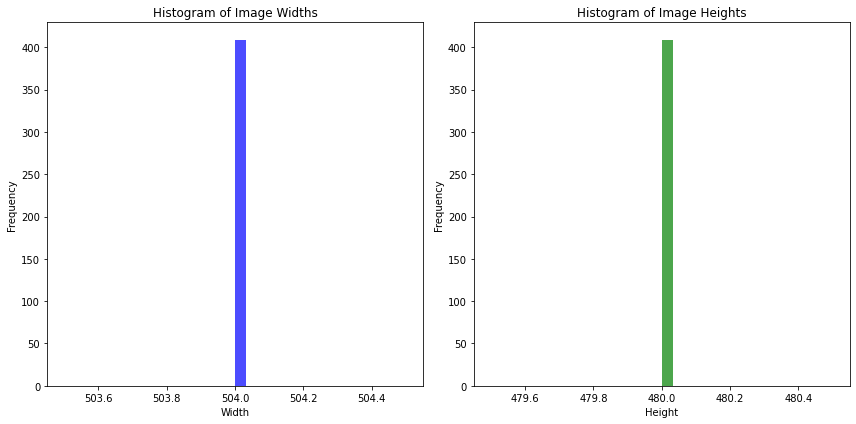

In [39]:
# Lists to store widths and heights
widths = []
heights = []

# Iterate through the dataset and collect image dimensions
for filename in os.listdir(dataset_dir):
        if img is not None:
            h, w = img.shape[:2]
            widths.append(w)
            heights.append(h)

# Create histograms for widths and heights
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

All images are in the size 504x480

## Histogram Equalization

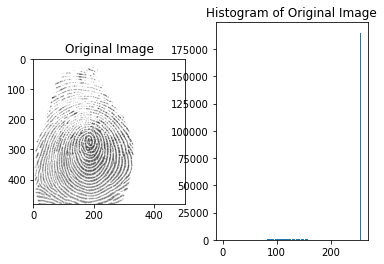

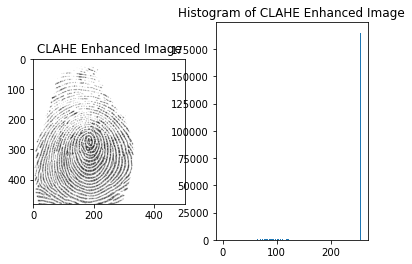

In [40]:
plt.figure()

# Assuming data is your set of images
img_test = image_data[30]  # Change index according to your dataset

# Plot original image and its histogram
plt.subplot(121)
plt.imshow(img_test, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.hist(img_test.ravel(), 256, [0, 256])
plt.title('Histogram of Original Image')

plt.show()


# Apply CLAHE to all images in the 'data' set
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
for i in range(len(image_data)):
    new = clahe.apply(image_data[i])
    image_data[i] = new

# Display the results after CLAHE
plt.figure()

# Plot CLAHE-enhanced image and its histogram for the same index
plt.subplot(121)
plt.imshow(image_data[30], cmap='gray')
plt.title('CLAHE Enhanced Image')

plt.subplot(122)
plt.hist(image_data[30].ravel(), 256, [0, 256])
plt.title('Histogram of CLAHE Enhanced Image')

plt.show()

## Median Filtering

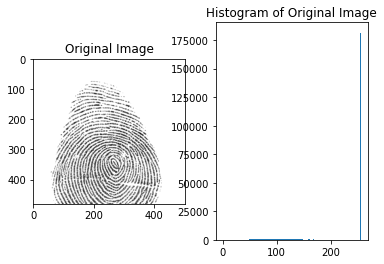

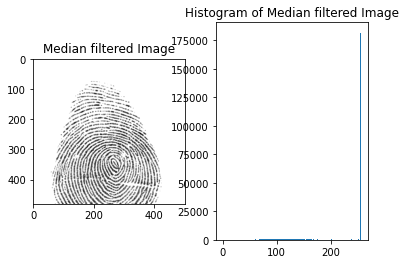

In [41]:
# Assuming real_img_set is your original set of images
img_test = image_data[77]

plt.figure()

# Plot original image and its histogram
plt.subplot(121)
plt.imshow(img_test, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.hist(img_test.ravel(), 256, [0, 256])
plt.title('Histogram of Original Image')

plt.show()


for i in range(len(image_data)):
    new = cv2.medianBlur(image_data[i], 3)
    image_data[i] = new

plt.figure()

plt.subplot(121)
plt.imshow(image_data[77], cmap='gray')
plt.title('Median filtered Image')

plt.subplot(122)
plt.hist(image_data[77].ravel(), 256, [0, 256])
plt.title('Histogram of Median filtered Image')

plt.show()

# Feature Extraction

In [42]:
# Initialize HOG descriptor
hog = cv2.HOGDescriptor()

# Extract features using HOG for each image
hog_features = []
for img in image_data:
    hog_img = cv2.resize(img, (64, 128), interpolation=cv2.INTER_AREA)  # Resize image to a common size for HOG
    features = hog.compute(hog_img)
    hog_features.append(features.flatten())

# Now 'hog_features' contains the extracted HOG features


# SVM

## Label encoding

In [43]:
# Combine person_id and finger_id into a single label
#combined_labels = ['{}_{}'.format(person_id, finger_id) for person_id, finger_id in labels]
combined_labels = [str(person_id) for person_id in person_labels]

# Use LabelEncoder to transform the combined labels into encoded integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(combined_labels)

# Now 'encoded_labels' contains the encoded target labels

print(len(encoded_labels))


408


## Model

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


features = hog_features  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)


# Define the parameter grid without 'gamma'
param_grid = {'C': np.arange(0.1, 5.2, 0.2),
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'sigmoid', 'linear', 'poly']}  # No 'gamma' specified here

# Initialize the SVM classifier
svm = SVC(class_weight='balanced')

# Initialize Stratified K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with Stratified K-fold
# scoring ở đây nên để là recall/f1 tuy nhiên code lại bị lỗi nếu để thế, ae nghiên cứu fix hộ
# n_jobs = -1 sẽ dùng full cpu, nếu muốn chỉ dùng 2 core, để n_jobs=2
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=skf, n_jobs=2, scoring='accuracy')

# Fit the data to perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)



Best Parameters: {'C': 0.30000000000000004, 'gamma': 1, 'kernel': 'linear'}


In [45]:
# Train the SVM model with the best parameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Predict on the test set
y_pred = best_svm.predict(X_test)

print(classification_report(y_test,y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.73      0.89      0.80         9
           2       0.75      0.90      0.82        10
           3       0.86      0.60      0.71        10
           4       0.80      0.80      0.80        10
           5       0.88      0.78      0.82         9
           6       1.00      0.70      0.82        10
           7       0.80      0.80      0.80         5
           8       0.77      1.00      0.87        10

    accuracy                           0.82        82
   macro avg       0.83      0.82      0.81        82
weighted avg       0.83      0.82      0.81        82

Accuracy: 0.8170731707317073
